# Using the Switching Regression to be Robust to Misclassification for Ethiopian Maize Adoption

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import pandas as pd
import numpy as np
from itertools import permutations
from linearmodels import PanelOLS
import sys
sys.path.append("../../uganda-uber-switching-reg/uganda_uber_switching_reg")
from mle import DriverSpecificProbUberMLE
from tqdm.notebook import tqdm
from io import StringIO
import matplotlib.pyplot as plt


In [3]:
df = pd.read_stata("../data/full_panel.zip")

trajectories = (
    df
    .dropna(subset= ['impmaize'])
    .groupby(['holder_id'])['impmaize']
    .agg(trajectories = list)
    .assign(len_traj = lambda df: df['trajectories'].apply(lambda x: len(x)))
    .query("len_traj == 3")
    .drop(['len_traj'], axis=1)
    .assign(trajectories = lambda df: df['trajectories'].astype(str))
    .pipe(pd.get_dummies)
    .rename(lambda x: x.replace('.0', '').replace(',', '').replace('[', '').replace(']', '').replace(' ', ''), axis=1)
    )

# merge with df

merged_df = (
    df
    .merge(trajectories, 
           left_on= ['holder_id'], 
           right_index=True)

    )




/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/pandas/io/stata.py:1514: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


In [4]:
# create misclassification matrices for each trajectory

purity_95 = pd.DataFrame(data=[[.863, .1370],
                              [.2958, .7042]], index=[0, 1], 
                                columns=[0,1])

dna_dtm = pd.DataFrame(data=[[.9709, .0291],
                              [.8678, .1322]], index=[0,1], 
                                columns=[0,1])

dna_2010 = pd.DataFrame(data=[[.859, .141],
                              [.6281, .3719]], index=[0,1], 
                                columns=[0,1])

In [5]:
from cProfile import label


with open("../results/tables/purity_table.tex", 'w') as f:
    f.write(purity_95.applymap(lambda x: f"{x:0.3f}").style.to_latex(hrules=True, label='tbl:purity95', caption='Misclassification for Pu'))
    
with open("../results/tables/dna_dtm_table.tex", 'w') as f:
    f.write(dna_dtm.applymap(lambda x: f"{x:0.3f}").style.to_latex(hrules=True, label='tbl:dna_dtm'))
    
with open("../results/tables/dna_2010_table.tex", 'w') as f:
    f.write(dna_2010.applymap(lambda x: f"{x:0.3f}").style.to_latex(hrules=True, label='tbl:dna_2010'))

In [6]:
trajectory_nums = trajectories.columns.str.replace("trajectories_", '').tolist()

In [7]:
# Now the magic...
# Need to take these static probabilities and turn the into a probability for each trajectory
# So my confusion matrix for each will be 2^3 x 2^3

trajectory_nums = trajectories.columns.str.replace("trajectories_", '').tolist()

def confusion_matrix(misclass_mat):
    confusion_matrix = pd.DataFrame(index=trajectory_nums, columns=trajectory_nums)
    
    for traj_self_reported in trajectory_nums:
        for traj_misclassified in trajectory_nums:
            traj_int_self_reported = [int(i) for i in list(traj_self_reported)]
            traj_int_misclassified = [int(i) for i in list(traj_misclassified)]
            confusion_matrix.loc[traj_self_reported, traj_misclassified] = \
                misclass_mat.loc[traj_int_self_reported[0], traj_int_misclassified[0]] * \
                    misclass_mat.loc[traj_int_self_reported[1], traj_int_misclassified[1]] * \
                        misclass_mat.loc[traj_int_self_reported[2], traj_int_misclassified[2]]
    
    return confusion_matrix
    

In [8]:
with open("../results/tables/misclass_95purity.tex", 'w') as f:
    
    f.write(confusion_matrix(purity_95).applymap(lambda x: f"{x:0.3f}").style.to_latex(hrules=True, 
                                                   label='tab:cm',
                                                   caption='Misclassification Matrix for Seed Adoption based on DNA Fingerprinting'))

In [9]:
# Let's see what happens!

trajectory_df = (
    merged_df
    .set_index(['holder_id', 'wave'])
    .filter(like='trajectories_')
    .idxmax(axis=1)
    .reset_index()
    .rename({0 : 'trajectories'}, axis=1)
    .assign(trajectories = lambda df: df['trajectories'].str.replace('trajectories_', ''))
    .merge(merged_df, on = ['holder_id', 'wave'])
    )

In [10]:
full_df = (
    trajectory_df
    .merge(trajectory_df[['wave', 'trajectories', 'impmaize']]
           .drop_duplicates(), on=['wave'], 
           suffixes=('_true', '_misclass'))
    .set_index(['holder_id', 'wave', 'trajectories_misclass'])
    .query("YIELD_cropcutdry_tr !=0")
    .assign(log_yield = lambda df: np.log(df['YIELD_cropcutdry_tr']))
    .dropna(subset=['log_yield', 'impmaize_misclass', 'yrseduc', "age_head", "sex_head",  'title', "parcesizeHA", "hhlabor", "hiredlabor", 'anntot_avg'])
    )

In [11]:
classifier_pred = (
    full_df
    .filter(like='trajectories_')
    .reset_index()
    .drop(columns=['trajectories_misclass', 'trajectories_true'])
    .drop_duplicates()
    .set_index(['holder_id', 'wave'])
    )

In [12]:
# Create nonlinear-MLE version of switching_reg for restricted model of GRC
from lib2to3.pgen2.driver import Driver
from scipy.stats import norm

class MisclassifiedGRC(DriverSpecificProbUberMLE):
    
    def _ll(self, params):                
        cm = self.cm.astype(float)

        # generate X so that we can for absorbed variables
        X = self.X
        
        if X.ndim ==1:
            raise Exception("Regimes not of equal size...")
        
        results_df = pd.Series(params, index=self._param_order)
        controls_df = results_df.loc[lambda df: ~df.index.str.contains('trajectories|impmaize|phi|sigma|mu_always')]
        beta_df = results_df.loc[~results_df.index.isin(['sigma', 'phi', 'mu_always'])]
        trajectories = beta_df.filter(regex='^trajectories_')
        trajectories_impmaize_names = self.exog_cat.filter(like='impmaize_misclass:').columns.tolist()        
        impmaize = beta_df.filter(regex='impmaize_misclass$').values[0]
        sigma = results_df.loc[results_df.index=='sigma'].values[0]
        phi = results_df.loc[results_df.index=='phi'].values[0]
        mu_always = results_df.loc[results_df.index=='mu_always'].values[0]
        
        # Now we build the expression
        # mu
        X_mu = X[:, :, self.exog_cat.columns.get_indexer(trajectories.index)]
        mu = X_mu @ trajectories.values
        
        # delta
        X_delta = X[:, :, self.exog_cat.columns.get_loc('impmaize_misclass')]
        delta = X_delta * impmaize
        
        # phi
        switcher_loc = (
            pd.Series(index=trajectories_impmaize_names, 
                                 data=self.exog_cat.columns.get_indexer(trajectories_impmaize_names))
            )
        
        trajectory_loc = (
            pd.Series(index=trajectories.index, 
                                 data=self.exog_cat.columns.get_indexer(trajectories.index))
            )
        
        base_trajectory = trajectories.loc['trajectories_001']
        x_base = X[:,:, trajectory_loc.loc['trajectories_001']]

        phi_exp = 0
        
        for name, param in trajectories.drop(['trajectories_000', 'trajectories_001']).iteritems():
            
            x_m = X[:,:, trajectory_loc.loc[name]]
            
            phi_exp += phi*((param*x_m) - (base_trajectory*x_base))*X[:,:, switcher_loc.loc[f"impmaize_misclass:{name}"]]
            
        # mu_always
        X_mu_always = (mu_always + phi*(mu_always - (base_trajectory*x_base)))*X[:,:, switcher_loc.loc['impmaize_misclass:trajectories_111']]
        
        # controls
        if not controls_df.empty:
            controls = X[:,:, self.exog_cat.columns.get_indexer(controls_df.index)] @ controls_df.values
            Xb = mu + delta + phi_exp + X_mu_always + controls
        else:
            Xb = mu + delta + phi_exp + X_mu_always
        
        rnl = norm.pdf(np.squeeze(self.y), Xb, scale=np.abs(sigma)).T

        # get row_maxes for probabilities
        row_maxes = self.p.max(axis=1, keepdims=True)
        class_ind = np.where(self.p==row_maxes, self.p, 0)
        return np.log((rnl*(class_ind@cm.T)).sum(axis=1))
    
    @property
    def exog_names(self):
        exog_names = [x for x in self.data.xnames \
            if x not in ['impmaize_misclass:trajectories_001',
                        'impmaize_misclass:trajectories_010',
                        'impmaize_misclass:trajectories_011',
                        'impmaize_misclass:trajectories_100',
                        'impmaize_misclass:trajectories_101',
                        'impmaize_misclass:trajectories_110',
                        'impmaize_misclass:trajectories_111'] 
            ]
        
        return exog_names + ['sigma', 'mu_always', 'phi']
    
    def fit(
        self,
        method=None,
        maxiter=10000,
        maxfun=5000,
        sigma_bound=None,
        cluster_var=None,
        show_ols=False,
        start_params_res=None,
        **kwds,
    ):

        results_df, pols_res = self._start_params(show_ols=show_ols, 
                                                  cluster_var=cluster_var,
                                                  start_params_res=start_params_res)
        
        self._param_order = results_df.loc[lambda df: ~ df.index.str.contains(r'impmaize_misclass:')].index.append(pd.Index(['mu_always', 'phi']))
        
        mu_always_start = self.endog_cat.loc[self.exog_cat['impmaize_misclass'] == 1].mean().values[0]
        phi_start = -0.1
        
        start_params = np.append(results_df.loc[lambda df: ~ df.index.str.contains(r'impmaize_misclass:')], 
                                 [[mu_always_start], [phi_start]])
        
        # if kwds.get('cov_type') is None:
        #     cov_type='cluster'
        #     cov_kwds = {'groups' : cluster_var,
        #                 'df_correction' : True,
        #                 'use_correction' : True}
        # else:
        #     cov_type = kwds.pop('cov_type', None)
        #     cov_kwds = kwds.pop('cov_kwds', None) 

        print("Optimizing...")
        optimize = super(DriverSpecificProbUberMLE, self).fit(
            method=method,
            start_params=start_params,
            maxiter=maxiter,
            maxfun=maxfun,
            eps=1e-08,
            ftol=1e-10,
            bounds=None,
            # cov_type= cov_type,
            # cov_kwds = cov_kwds,
            use_t=True,
            **kwds
        )
        
        return optimize, pols_res
    
no_stayers = classifier_pred.drop(columns=['trajectories_111']).columns.tolist()
switchers = classifier_pred.drop(columns=['trajectories_000']).columns.tolist()

formula = "log_yield ~ -1 + " + ' + '.join(no_stayers) + ' + ' \
        + ' + '.join([f"{s}:impmaize_misclass" for s in switchers])\
                + '+ impmaize_misclass + yrseduc + age_head +  sex_head +  title + parcesizeHA + hhlabor+ hiredlabor' 

res = PanelOLS.from_formula(formula, 
                            data=full_df.reset_index('trajectories_misclass').query("trajectories_true==trajectories_misclass"),
                            check_rank=False).fit()

mod = MisclassifiedGRC.from_formula(formula, 
                            data=full_df, 
                            classifier_pred = classifier_pred,
                            check_absorbed=False,
                            cm = confusion_matrix(purity_95).T.values)

sr, pols = mod.fit(method='bfgs',
        start_params_res=res)



Initializing...
exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False. skipping...
Creating starting values...
Optimizing...


/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: eps, ftol, bounds, maxfun. After release 0.14, this will raise.
  warnings.warn(
/var/folders/22/d2d1hrtn3kl9cq0gsx95c6lr0000gn/T/ipykernel_25075/229419683.py:72: RuntimeWarning: divide by zero encountered in log
  return np.log((rnl*(class_ind@cm.T)).sum(axis=1))
/var/folders/22/d2d1hrtn3kl9cq0gsx95c6lr0000gn/T/ipykernel_25075/229419683.py:72: RuntimeWarning: divide by zero encountered in log
  return np.log((rnl*(class_ind@cm.T)).sum(axis=1))
/var/folders/22/d2d1hrtn3kl9cq0gsx95c6lr0000gn/T/ipykernel_25075/229419683.py:72: RuntimeWarning: divide by zero encountered in log
  return np.log((rnl*(class_ind@cm.T)).sum(axis=1))
/var/folders/22/d2d1hrtn

Optimization terminated successfully.
         Current function value: 0.170921
         Iterations: 99
         Function evaluations: 115
         Gradient evaluations: 107


/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


In [13]:
mod_unrestricted = DriverSpecificProbUberMLE.from_formula(
    formula=formula,
    data=full_df,
    classifier_pred=classifier_pred,
    cm=confusion_matrix(purity_95).T.values,
    check_absorbed=False
)

sr_unres, pols_unres = mod_unrestricted.fit(method='bfgs',
        start_params_res=res, cov_type='cluster',
        cov_kwds={'groups' : full_df.reset_index('trajectories_misclass').query("trajectories_misclass == trajectories_true").trajectories_true})

/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: eps, ftol, bounds, maxfun. After release 0.14, this will raise.
  warnings.warn(
/Users/lordflaron/Documents/ethiopia-tech-adoption/python/../../uganda-uber-switching-reg/uganda_uber_switching_reg/mle.py:375: RuntimeWarning: divide by zero encountered in log
  return np.log((rnl*(class_ind@cm.T)).sum(axis=1))
/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/tools/numdiff.py:157: RuntimeWarning: invalid value encountered in double_scalars
  grad[k, :] = (f(*((x+ei,)+args), **kwargs) -
/Users/lordflaron/Documents/ethiopia-tech-adoption/python/../../uganda-uber-switching-reg/uganda_uber_switching_reg/mle.p

Initializing...
exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False. skipping...
Creating starting values...
Optimizing...
Optimization terminated successfully.
         Current function value: 0.170267
         Iterations: 189
         Function evaluations: 210
         Gradient evaluations: 202


/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


In [14]:
sr_unres.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          DriverSpecificProbUberMLE Results                          
=====================================================================================
Dep. Variable:                     log_yield   Log-Likelihood:                -1291.3
Model:             DriverSpecificProbUberMLE   AIC:                             2625.
Method:                   Maximum Likelihood   BIC:                             2770.
Date:                       Thu, 13 Oct 2022                                         
Time:                               15:38:55                                         
No. Observations:                       7584                                         
Df Residuals:                           7562                                         
Df Model:                                 21                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
age_head                               0.0035      0.001      3.267      0.014       0.001       0.006
hhlabor                               -0.0037      0.000     -8.138      0.000      -0.005      -0.003
hiredlabor                             0.0004   7.64e-05      5.840      0.001       0.000       0.001
impmaize_misclass                      0.4651      0.214      2.177      0.066      -0.040       0.970
parcesizeHA                           -0.0037      0.004     -0.937      0.380      -0.013       0.006
sex_head                              -0.1048      0.056     -1.881      0.102      -0.236       0.027
title                                  0.1262      0.036      3.469      0.010       0.040       0.212
trajectories_000                       6.2909      0.079     79.621      0.000       6.104       6.478
trajectories_001                       6.3698      0.079     80.477      0.000       6.183       6.557
trajectories_010                       6.5809      0.079     83.030      0.000       6.394       6.768
trajectories_011                       6.9943      0.108     64.693      0.000       6.739       7.250
trajectories_100                       6.6787      0.103     64.661      0.000       6.434       6.923
trajectories_101                       6.5227      0.087     74.754      0.000       6.316       6.729
trajectories_110                       6.2743      0.090     69.454      0.000       6.061       6.488
yrseduc                               -0.0039      0.013     -0.303      0.770      -0.035       0.027
impmaize_misclass:trajectories_001     0.5254      0.144      3.643      0.008       0.184       0.866
impmaize_misclass:trajectories_010    -0.5288      0.181     -2.923      0.022      -0.957      -0.101
impmaize_misclass:trajectories_011    -1.7556      0.283     -6.193      0.000      -2.426      -1.085
impmaize_misclass:trajectories_100    -0.8400      0.298     -2.818      0.026      -1.545      -0.135
impmaize_misclass:trajectories_101     0.0109      0.181      0.060      0.954      -0.416       0.438
impmaize_misclass:trajectories_110     0.4349      0.092      4.726      0.002       0.217       0.653
impmaize_misclass:trajectories_111     6.2369      0.176     35.411      0.000       5.820       6.653
par0                                   0.8532      0.046     18.440      0.000       0.744       0.963
======================================================================================================
"""

In [15]:
full_df_short = full_df.reset_index('trajectories_misclass').query("trajectories_true==trajectories_misclass")

In [16]:
sr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           MisclassifiedGRC Results                           
==============================================================================
Dep. Variable:              log_yield   Log-Likelihood:                -1296.3
Model:               MisclassifiedGRC   AIC:                             2635.
Method:            Maximum Likelihood   BIC:                             2780.
Date:                Thu, 13 Oct 2022                                         
Time:                        15:38:55                                         
No. Observations:                7584                                         
Df Residuals:                    7562                                         
Df Model:                          21                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
age_head              0.0034      0.002      1.562      0.118      -0.001       0.008
hhlabor              -0.0037      0.001     -7.265      0.000      -0.005      -0.003
hiredlabor            0.0005      0.000      0.922      0.356      -0.001       0.001
impmaize_misclass     0.5236      0.197      2.664      0.008       0.138       0.909
parcesizeHA          -0.0034      0.016     -0.218      0.827      -0.034       0.027
sex_head             -0.1108      0.090     -1.229      0.219      -0.288       0.066
title                 0.1248      0.062      2.010      0.045       0.003       0.247
trajectories_000      6.2936      0.153     41.222      0.000       5.994       6.593
trajectories_001      6.5111      0.194     33.583      0.000       6.131       6.891
trajectories_010      6.6840      0.228     29.338      0.000       6.237       7.131
trajectories_011      6.7157      0.227     29.526      0.000       6.270       7.162
trajectories_100      6.7138      0.269     24.916      0.000       6.186       7.242
trajectories_101      7.0305      0.321     21.893      0.000       6.401       7.660
trajectories_110      7.1956      0.323     22.296      0.000       6.563       7.828
yrseduc              -0.0020      0.011     -0.185      0.854      -0.024       0.020
sigma                 0.8681      0.024     36.566      0.000       0.822       0.915
mu_always             7.2144      0.409     17.651      0.000       6.413       8.016
phi                  -0.1417      0.057     -2.492      0.013      -0.253      -0.030
=====================================================================================
"""

In [17]:
mu_freq = merged_df.filter(like='trajectories_').replace().idxmax(axis=1).value_counts(normalize=True, sort=False)

mu_freq.index = mu_freq.index.str.replace("trajectories_", '')

# get mus from sr
sr_df = (
    pd.read_csv(StringIO(sr.summary().tables[1].as_csv()))
    .rename(lambda x: str.strip(x), axis=1)
    .set_index('')
    .rename(index=lambda x: str.strip(x))
    .reset_index()      
    .rename({'' : 'vars'},axis=1)
    .set_index('vars')
    )

In [18]:
# calculate theta

mus = sr_df.filter(regex='trajectories|mu_always', axis=0).coef.values

trajectory_order = ['000', '001', '010', '011', '100', '101', '110', '111']

E_mu = (mu_freq.reindex(trajectory_order).values # reindex so that they're in the same order 
    * mus).sum()

In [19]:
# calculate returns
returns_dict = {k : 0 for k in trajectory_order}

phi = sr_df.query("index == 'phi'").coef.values[0]
mu_always = sr_df.query("index == 'mu_always'").coef.values[0]
base_trajectory = sr_df.query("index == 'trajectories_001'").coef.values[0]
beta = sr_df.query("index == 'impmaize_misclass'").coef.values[0]

## First we do mu_always
returns_dict['111'] = phi*(mu_always - base_trajectory) - beta

## for base
returns_dict['001'] = beta

## Now the rest...
for traj in ['000', '010', '011', '100', '101', '110']:
    returns_dict[traj] = phi*(sr_df.query(f"index == 'trajectories_{traj}'").coef.values[0] - base_trajectory) - beta


In [20]:
mu_df = pd.DataFrame(data = mus-E_mu, index=trajectory_order, columns=['theta'])

returns_df = pd.DataFrame(data=returns_dict.values(), index=returns_dict.keys(), columns=['returns'])

# Load GMM Data
gmm_df = pd.read_csv("../results/data/theta.csv").assign(trajectory=trajectory_order).set_index('trajectory')

In [21]:
theta_all = mu_df.merge(gmm_df, left_index=True, right_index=True, suffixes=('_misclass', '_normal'))
returns_all = returns_df.merge(theta_all, left_index=True, right_index=True, suffixes=('_misclass', '_normal'))


In [22]:
full_df_short_theta = full_df_short.merge(theta_all, left_on=['trajectories_true'], right_index=True)

In [23]:
full_df_short.columns.tolist()

['trajectories_misclass',
 'trajectories_true',
 'household_id',
 'seedtype',
 'harvest_kg',
 'parcesizeHA',
 'parcesizeHA_wiz',
 'urea_kg',
 'dap_kg',
 'hhlabor',
 'hiredmen',
 'hiredwomen',
 'hiredchildren',
 'hiredlabor',
 'labcostsmen',
 'labcostswomen',
 'labcostschildren',
 'laborcosts',
 'othhlabor',
 'hiredmen_harv',
 'hiredwomen_harv',
 'hiredchildren_harv',
 'hiredlabor_harv',
 'labcostsmen_harv',
 'labcostswomen_harv',
 'labcostschildren_harv',
 'laborcosts_harv',
 'hhlabor_harv',
 'othhlabor_harv',
 'cropcutfresh_KG',
 'cropcutdry_KG',
 'intercropshare',
 'damaged_share',
 'pctcropdamage',
 'intercrop',
 'prevented',
 'pesticide',
 'herbicide',
 'fungicide',
 'damaged',
 'cropmethod',
 'fieldslope',
 'irrigationsource',
 'durea',
 'ddap',
 'dcompost',
 'dorganicfert',
 'dirrigation',
 'typecrop',
 'lessthanplanted',
 'dcropdamage',
 'impmaize_true',
 'YIELD_cropcutfresh',
 'YIELD_cropcutdry',
 'YIELD_cropcutfresh_tr',
 'YIELD_cropcutdry_tr',
 'YIELD_selfr',
 'YIELD_selfr_tr

In [24]:
PanelOLS.from_formula("theta_normal ~ eviarea_avg + dist_road + dist_popcenter + dist_market + dist_borderpost + dist_admctr", data=full_df_short_theta).fit(cov_type='clustered',
                                                                                  cluster_entity=True)

Dep. Variable:,theta_normal,R-squared:,0.0316
Estimator:,PanelOLS,R-squared (Between):,0.0255
No. Observations:,948,R-squared (Within):,-1.218e+28
Date:,"Thu, Oct 13 2022",R-squared (Overall):,0.0316
Time:,15:38:55,Log-likelihood,289.67
Cov. Estimator:,Clustered,,
,,F-statistic:,5.1301
Entities:,1116,P-value,0.0000
Avg Obs:,0.8495,Distribution:,"F(6,942)"
Min Obs:,0.0000,,
Max Obs:,3.0000,F-statistic (robust):,4.3061


In [25]:
PanelOLS.from_formula("theta_misclass ~ eviarea_avg + dist_road + dist_popcenter + dist_market + dist_borderpost + dist_admctr", data=full_df_short_theta).fit(cov_type='clustered',
                                                                                  cluster_entity=True)

Dep. Variable:,theta_misclass,R-squared:,0.1399
Estimator:,PanelOLS,R-squared (Between):,0.1251
No. Observations:,948,R-squared (Within):,0.0000
Date:,"Thu, Oct 13 2022",R-squared (Overall):,0.1399
Time:,15:38:55,Log-likelihood,-288.98
Cov. Estimator:,Clustered,,
,,F-statistic:,25.547
Entities:,1116,P-value,0.0000
Avg Obs:,0.8495,Distribution:,"F(6,942)"
Min Obs:,0.0000,,
Max Obs:,3.0000,F-statistic (robust):,24.908


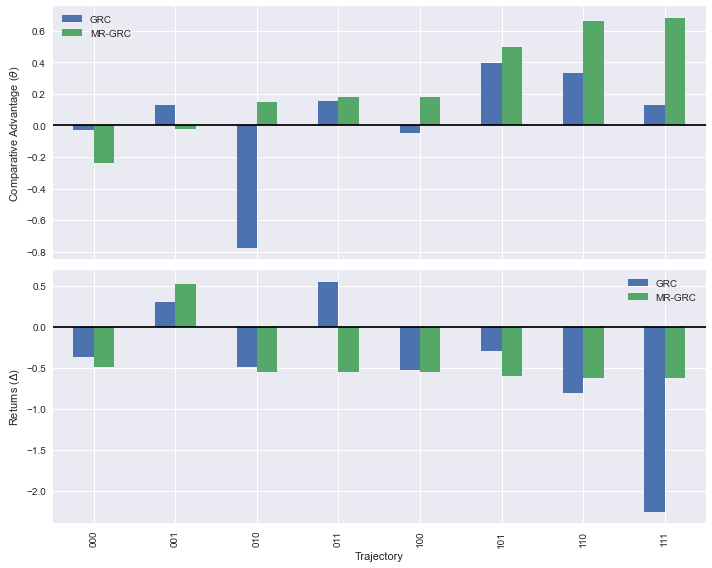

In [26]:
plt.style.use('seaborn')

fig, ax = plt.subplots(2,1, sharex=True, figsize=(10,8))

# Theta
theta_all[[ 'theta_normal', 'theta_misclass']].plot.bar(ax=ax[0], legend=False)

# Returns
returns_all[['returns_normal', 'returns_misclass']].plot.bar(ax=ax[1], legend=False)

ax[0].legend(['GRC', 'MR-GRC'])
ax[1].legend(['GRC', 'MR-GRC'])

ax[0].axhline(0, color='black')
ax[1].axhline(0, color='black')

ax[0].set_ylabel(r"Comparative Advantage ($\theta$)")
ax[1].set_ylabel("Returns ($\Delta$)")
ax[1].set_xlabel("Trajectory")


plt.tight_layout()\

plt.savefig("../results/figures/mr-theta.png", dpi=300)

## Number of Times Adopted

In [27]:
num_adoption_df = (
    pd.read_csv("../results/data/num_adoption.csv")
)

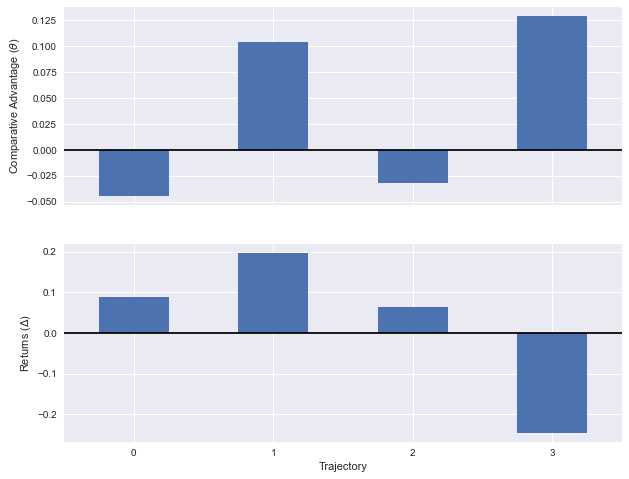

In [31]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(10,8))

num_adoption_df['theta'].plot.bar(ax=ax[0])

num_adoption_df['returns'].plot.bar(ax=ax[1])

ax[0].axhline(0, color='black')
ax[1].axhline(0, color='black')

ax[0].set_ylabel(r"Comparative Advantage ($\theta$)")
ax[1].set_ylabel("Returns ($\Delta$)")
ax[1].set_xlabel("Trajectory")

ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

plt.savefig("../results/figures/num_adoption.png", dpi=300)

## Do Weak-ID Procedure

In [29]:
def weak_id_test(res, start=-100, stop=100, inc=0.1, adoption_col = 'impmaize'):
    trajectories = np.array(["010", "011", "100", "101", "110"])
    ranger = np.arange(start, stop, inc)
    mat = np.zeros((ranger.size, trajectories.size))
    for i, phi in enumerate(tqdm(ranger)):
        for j, traj in enumerate(trajectories):
            test = f"trajectories_{traj} - trajectories_001 = {phi}*({adoption_col}:trajectories_{traj} - {adoption_col}:trajectories_001)"
            mat[i, j] = res.t_test(test).pvalue
            
    df= pd.DataFrame(columns = trajectories,
                 index = pd.Index(ranger),
                 data=mat)
            
    return df

def weak_id_joint_test(res, start=-100, stop=100, inc=0.1, adoption_col='impmaize'):
    
    trajectories = np.array(["010", "011", "100", "101", "110"])
    ranger = np.arange(start, stop, inc)
    mat = np.zeros(ranger.size)
    
    for i, phi in enumerate(tqdm(ranger)):
        joint_test_list = [f"(trajectories_{traj} - trajectories_001 = {phi}*({adoption_col}:trajectories_{traj} - {adoption_col}:trajectories_001))" \
            for traj in trajectories]
    
        joint_test = ' , '.join(joint_test_list)
        mat[i] = res.f_test(joint_test).pvalue

    df= pd.DataFrame(columns = ['joint'],
                 index = pd.Index(ranger),
                 data=mat)
            
    return df

def phi_ci(weak_id_df):
    
    phi_p_min = weak_id_df[weak_id_df.apply(lambda x: x > 0.05)].min()
    phi_p_max = weak_id_df[weak_id_df.apply(lambda x: x > 0.05)].max()
    
    phi_df = pd.DataFrame(
        index = ['min', 'max'],
        columns = weak_id_df.columns
    )
    
    for col, mi, ma in zip(weak_id_df.columns, phi_p_min, phi_p_max):
        try:
            phi_df.loc['min', col] = weak_id_df.index[weak_id_df[col] == mi].values[0]
            phi_df.loc['max', col] = weak_id_df.index[weak_id_df[col] == ma].values[0]
        except IndexError:
            print(f"""Might be NaNs: 
                  phi_min = {phi_p_min.values[0]}
                  phi_max = {phi_p_max.values[0]}
                  """)
        
    return phi_df

In [30]:
weak_id_test = weak_id_test(sr, adoption_col='impmaize_misclass')

  0%|          | 0/2000 [00:00<?, ?it/s]

ValueError: r_matrix and params are not aligned

In [ ]:
joint_test = weak_id_joint_test(sr, adoption_col='impmaize_misclass')

: 

In [ ]:
phi_ci(weak_id_test)

: 

In [ ]:
phi_ci(joint_test)

: 